In [1]:
import numpy as np
import json
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

### Obtaining data setting up the dataframe

In [18]:
# Get data from api in json format
API_KEY = 'pk_68faf40447a04a129a4b45b974b1ac2a'

stock_symbols = [
    'aapl',
    'msft',
    'intc',
    'amd',
    'ebay',
    'amzn'
]

def download_stocks_data(stock_list, iex_api_key):
    request = 'https://cloud.iexapis.com/beta/stock/{stock}/chart/5y?token={api_key}'
    requests.get(REQUEST).json()
    return list(map(lambda stock: (stock, requests.get(request.format(stock=stock, api_key=iex_api_key)).json()), stock_symbols))
    
def format_stock_data_response(response, stock):
    df = pd.DataFrame(response)
    df.index = pd.DatetimeIndex(df.date)
    features = ['open', 'close', 'low', 'high']
    df = df[features]

    # (0,1) normalization
    df_normalized = (df - df.min()) / (df.max() - df.min())
    df_normalized.columns = [col + "_normalized" for col in df.columns]

    # Add normalized columns to original dataframe
    data = pd.concat([df, df_normalized], axis=1, sort=False)
    data.to_csv('./data/{0}.csv'.format(stock))
    return data

In [19]:
stock_data = download_stocks_data(stock_symbols, API_KEY)

formatted_data = list(map(lambda stock: format_stock_data_response(stock[1], stock[0]), stock_data))

### Kallman filterring

In [6]:
def kallman_filterring1d(data, 
                         process_variance,
                         measurement_variance,
                         initial_error_estimate=0.5):
    data_size = len(data)
    matrix_size = (data_size,)
    
    # Space allocation
    prev_estimate = np.zeros(matrix_size)
    estimate = np.zeros(matrix_size)
    prev_error_estimate = np.zeros(matrix_size)
    error_estimate = np.zeros(matrix_size)
    gain = np.zeros(matrix_size)
    
    # Initial guesses
    estimate[0] = data[0]
    error_estimate[0] = initial_error_estimate
    
    for step in range(1, data_size):
        # Time update
        prev_step = step - 1
        prev_estimate[step] = estimate[prev_step]
        prev_error_estimate[step] = prev_error_estimate[prev_step] + process_variance
        
        # Measurment update
        gain[step] = prev_error_estimate[step] / (prev_error_estimate[step] + measurement_variance)
        estimate[step] = prev_estimate[step] + gain[step] * (data[step] - prev_estimate[step])
        error_estimate[step] = (1 - gain[step]) * prev_error_estimate[step] 
        
    return estimate

In [7]:
stock_open_estimates = kallman_filterring1d(data=df.open.values.tolist(),
                                            process_variance=1e-4,
                                            measurement_variance=0.5)

stock_open_normalized_estimates = kallman_filterring1d(data=stock_open_normalized.values.tolist(),
                                                        process_variance=1e-4,
                                                        measurement_variance=0.5)

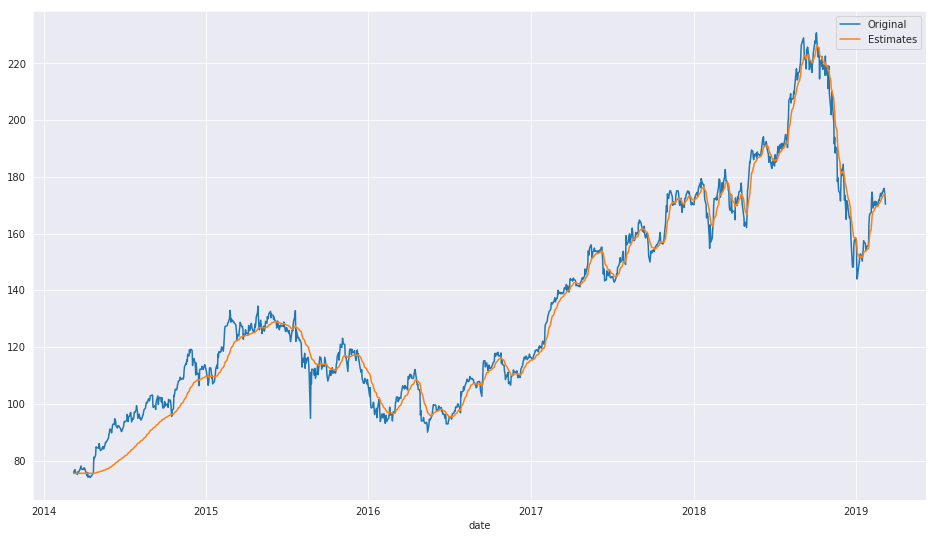

In [8]:
fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x=stock_open_normalized.index, y=df.open.values, ax=ax, ci=None)
sns.lineplot(x=stock_open_normalized.index, y=stock_open_estimates, ax=ax, ci=None)
plt.legend(['Original','Estimates'])
plt.show()

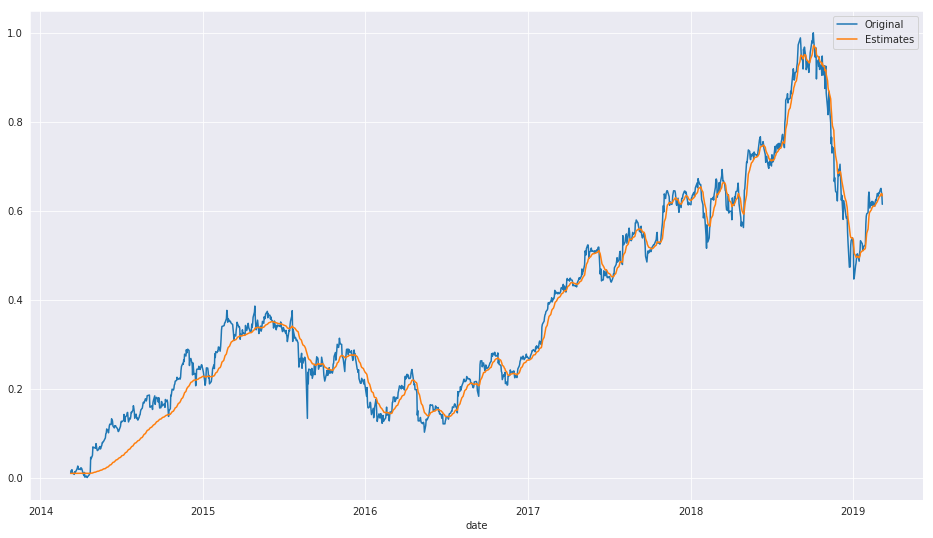

In [9]:
fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x=stock_open_normalized.index, y=stock_open_normalized.values, ax=ax, ci=None)
sns.lineplot(x=stock_open_normalized.index, y=stock_open_normalized_estimates, ax=ax, ci=None)
plt.legend(['Original','Estimates'])
plt.show()